### Wider Face Set을 이용하여 스티커 붙이기
---
- [WIDERFACE](http://shuoyang1213.me/WIDERFACE/index.html)
  
    
-  mkdir -p ~/aiffel/face_detector/assets
- mkdir -p ~/aiffel/face_detector/dataset
- mkdir -p ~/aiffel/face_detector/widerface  
  
    
-  cd ~/aiffel/face_detector
- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/face_detector.zip -P ~/aiffel/face_detector
- unzip face_detector.zip

### 데이터셋 전처리 (1) 분석
#### WIDER FACE Bounding Box
---
```
[이미지 파일 경로]
0--Parade/0_Parade_marchingband_1_849.jpg
[face bounding box 갯수]
1
[face bounding box 좌표 등 상세정보]
449 330 122 149 0 0 0 0 0 0 
```

In [1]:
def get_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

In [2]:
# 이미지별 bounding box 정보를 wider_face_train_bbx_gt.txt에서 파싱해서 리스트로 추출

def parse_widerface(config_path):
    boxes_per_img = []
    with open(config_path) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            num_of_obj = int(fp.readline())
            boxes = []
            for i in range(num_of_obj):
                obj_box = fp.readline().split(' ')
                x0, y0, w, h = get_box(obj_box)
                if w == 0:
                    # remove boxes with no width
                    continue
                if h == 0:
                    # remove boxes with no height
                    continue
                # Because our network is outputting 7x7 grid then it's not worth processing images with more than
                # 5 faces because it's highly probable they are close to each other.
                # You could remove this filter if you decide to switch to larger grid (like 14x14)
                # Don't worry about number of train data because even with this filter we have around 16k samples
                boxes.append([x0, y0, w, h])
            if num_of_obj == 0:
                obj_box = fp.readline().split(' ')
                x0, y0, w, h = get_box(obj_box)
                boxes.append([x0, y0, w, h])
            boxes_per_img.append((line.strip(), boxes))
            line = fp.readline()
            cnt += 1

    return boxes_per_img

In [3]:
# boudbing box 정보는 [x, y, w, h] 형태로 저장되어 있는데, 아래 코드를 통해 x_min, y_min, x_max, y_max 형태의 꼭지점 좌표 정보로 변환하여 출력
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        logging.info('{}: Invalid JPEG data or crop window'.format(image_file))
        return 1, image_string, None

In [4]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

In [5]:
import os
import tensorflow as tf
dataset_path = os.getenv('HOME')+'/aiffel/face_detector/widerface'
anno_txt = 'wider_face_train_bbx_gt.txt'
file_path = 'WIDER_train'
for i, info in enumerate(parse_widerface(os.path.join(dataset_path, 'wider_face_split', anno_txt))):
    print('--------------------')
    image_file = os.path.join(dataset_path, file_path, 'images', info[0])
    error, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/home/ssac24/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/home/ssac24/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/home/ssac24/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 22

### 데이터셋 전처리 (2) tf_example 생성
#### tfrecord 만들기

In [6]:
def make_example(image_string, image_info_list):

    for info in image_info_list:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]

    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    return example

In [7]:
import logging
import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
rootPath = os.getenv('HOME')+'/aiffel/face_detector'
dataset_path = 'widerface'

if not os.path.isdir(dataset_path):
    logging.info('Please define valid dataset path.')
else:
    logging.info('Loading {}'.format(dataset_path))

logging.info('Reading configuration...')

for split in ['train', 'val']:
    output_file = rootPath + '/dataset/train_mask.tfrecord' if split == 'train' else rootPath + '/dataset/val_mask.tfrecord'

    with tf.io.TFRecordWriter(output_file) as writer:

        counter = 0
        skipped = 0
        anno_txt = 'wider_face_train_bbx_gt.txt' if split == 'train' else 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_train' if split == 'train' else 'WIDER_val'
        for info in tqdm.tqdm(parse_widerface(os.path.join(rootPath, dataset_path, 'wider_face_split', anno_txt))):
            image_file = os.path.join(rootPath, dataset_path, file_path, 'images', info[0])

            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])

                writer.write(tf_example.SerializeToString())
                counter += 1

            else:
                skipped += 1
                logging.info('Skipped {:d} of {:d} images.'.format(skipped, counter))

    logging.info('Wrote {} images to {}'.format(counter, output_file))

100%|██████████| 3226/3226 [00:09<00:00, 335.38it/s]


- cd ~/aiffel/face_detector && python tf_dataset_preprocess.py

### 모델 구현(1) priors box
#### SSD의 prior box
- [Understand Single Shot MultiBox Detector (SSD) and Implement It in Pytorch](https://medium.com/@smallfishbigsea/understand-ssd-and-implement-your-own-caa3232cd6ad)
- [Understanding SSD MultiBox — Real-Time Object Detection In Deep Learning](https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab)
  
![priors box](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GC-4-L-9.anchorbox.png)  
- object가 존재할 만한 다양한 크기의 box의 좌표 및 클래스 정보를 일정 개수만큼 고정해두어 ground truth에 해당하는 bounding box와의 IoU를 계산하여 일정 이상(0.5) 겹치는 prior box를 선택하는 방식이 RCNN 계열의 sliding window 방식보다 훨씬 속도가 빠르고 정확하다

In [8]:
cfg = {
    # general setting
    "batch_size": 32,
    "input_size": (240, 320),  # (h,w)

    # training dataset
    "dataset_path": 'dataset/train_mask.tfrecord',  # 'dataset/trainval_mask.tfrecord'
    "val_path": 'dataset/val_mask.tfrecord',  #
    "dataset_len": 12880,  # train 6115 , trainval 7954, number of training samples
    "val_len": 3226,
    "using_crop": True,
    "using_bin": True,
    "using_flip": True,
    "using_distort": True,
    "using_normalizing": True,
    "labels_list": ['background', 'face'],  # xml annotation

    # anchor setting
    "min_sizes":[[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]],
    "steps": [8, 16, 32, 64],
    "match_thresh": 0.45,
    "variances": [0.1, 0.2],
    "clip": False,

    # network
    "base_channel": 16,

    # training setting
    "resume": False,  # if False,training from scratch
    "epoch": 100,
    "init_lr": 1e-2,
    "lr_decay_epoch": [50, 70],
    "lr_rate": 0.1,
    "warmup_epoch": 5,
    "min_lr": 1e-4,

    "weights_decay": 5e-4,
    "momentum": 0.9,
    "save_freq": 10, #frequency of save model weights

    # inference
    "score_threshold": 0.5,
    "nms_threshold": 0.4,
    "max_number_keep": 200
}

cfg

{'batch_size': 32,
 'input_size': (240, 320),
 'dataset_path': 'dataset/train_mask.tfrecord',
 'val_path': 'dataset/val_mask.tfrecord',
 'dataset_len': 12880,
 'val_len': 3226,
 'using_crop': True,
 'using_bin': True,
 'using_flip': True,
 'using_distort': True,
 'using_normalizing': True,
 'labels_list': ['background', 'face'],
 'min_sizes': [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]],
 'steps': [8, 16, 32, 64],
 'match_thresh': 0.45,
 'variances': [0.1, 0.2],
 'clip': False,
 'base_channel': 16,
 'resume': False,
 'epoch': 100,
 'init_lr': 0.01,
 'lr_decay_epoch': [50, 70],
 'lr_rate': 0.1,
 'warmup_epoch': 5,
 'min_lr': 0.0001,
 'weights_decay': 0.0005,
 'momentum': 0.9,
 'save_freq': 10,
 'score_threshold': 0.5,
 'nms_threshold': 0.4,
 'max_number_keep': 200}

In [9]:
image_sizes = cfg['input_size']
min_sizes = cfg["min_sizes"]
steps = cfg["steps"]
clip = cfg["clip"]

if isinstance(image_sizes, int):
    image_sizes = (image_sizes, image_sizes)
elif isinstance(image_sizes, tuple):
    image_sizes = image_sizes
else:
    raise Exception('Type error of input image size format,tuple or int. ')

print(image_sizes)

(240, 320)


![pb](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-11-P-06.max-800x600.png)

In [10]:
import math
import numpy as np
from itertools import product

for m in range(4):
    if (steps[m] != pow(2, (m + 3))):
        print("steps must be [8,16,32,64]")
        sys.exit()

assert len(min_sizes) == len(steps), "anchors number didn't match the feature map layer."

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps]

feature_maps

[[30, 40], [15, 20], [8, 10], [4, 5]]

In [11]:
anchors = []
num_box_fm_cell=[]
for k, f in enumerate(feature_maps):
    num_box_fm_cell.append(len(min_sizes[k]))
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            if isinstance(min_size, int):
                min_size = (min_size, min_size)
            elif isinstance(min_size, tuple):
                min_size=min_size
            else:
                raise Exception('Type error of min_sizes elements format,tuple or int. ')
            s_kx = min_size[1] / image_sizes[1]
            s_ky = min_size[0] / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            anchors += [cx, cy, s_kx, s_ky]

len(anchors)

17680

In [12]:
import numpy as np
priors = np.asarray(anchors).reshape([-1, 4])
priors.shape

(4420, 4)

In [13]:
priors

array([[0.0125    , 0.01666667, 0.03125   , 0.04166667],
       [0.0125    , 0.01666667, 0.05      , 0.06666667],
       [0.0125    , 0.01666667, 0.075     , 0.1       ],
       ...,
       [0.9       , 0.93333333, 0.4       , 0.53333333],
       [0.9       , 0.93333333, 0.6       , 0.8       ],
       [0.9       , 0.93333333, 0.8       , 1.06666667]])

- cd ~/aiffel/face_detector && python make_prior_box.py

In [14]:
# 정리
def prior_box(cfg,image_sizes=None):
    """prior box"""
    if image_sizes is None:
        image_sizes = cfg['input_size']
    min_sizes=cfg["min_sizes"]
    steps=cfg["steps"]
    clip=cfg["clip"]

    if isinstance(image_sizes, int):
        image_sizes = (image_sizes, image_sizes)
    elif isinstance(image_sizes, tuple):
        image_sizes = image_sizes
    else:
        raise Exception('Type error of input image size format,tuple or int. ')

    for m in range(4):
        if (steps[m] != pow(2, (m + 3))):
            print("steps must be [8,16,32,64]")
            sys.exit()

    assert len(min_sizes) == len(steps), "anchors number didn't match the feature map layer."

    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps]

    anchors = []
    num_box_fm_cell=[]
    for k, f in enumerate(feature_maps):
        num_box_fm_cell.append(len(min_sizes[k]))
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                if isinstance(min_size, int):
                    min_size = (min_size, min_size)
                elif isinstance(min_size, tuple):
                    min_size=min_size
                else:
                    raise Exception('Type error of min_sizes elements format,tuple or int. ')
                s_kx = min_size[1] / image_sizes[1]
                s_ky = min_size[0] / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                anchors += [cx, cy, s_kx, s_ky]

    output = np.asarray(anchors).reshape([-1, 4])

    if clip:
        output = np.clip(output, 0, 1)
    return output,num_box_fm_cell

### 모델 구현(2) SSD

In [15]:
import tensorflow as tf

def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1), use_bn=True, padding=None, block_id=None):
    """Adds an initial convolution layer (with batch normalization and relu).
    # Returns
        Output tensor of block.
    """
    if block_id is None:
        block_id = (tf.keras.backend.get_uid())

    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False if use_bn else True,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False if use_bn else True,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    if use_bn:
        x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

In [16]:
def _depthwise_conv_block(inputs, pointwise_conv_filters,
                          depth_multiplier=1, strides=(1, 1), use_bn=True, block_id=None):
    """Adds a depthwise convolution block.
        # Returns
        Output tensor of block.
    """
    if block_id is None:
        block_id = (tf.keras.backend.get_uid())

    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)

    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        depth_multiplier=depth_multiplier,
                                        strides=strides,
                                        use_bias=False if use_bn else True,
                                        name='conv_dw_%d' % block_id)(x)
    if use_bn:
        x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)

    x = tf.keras.layers.Conv2D(pointwise_conv_filters, (1, 1),
                               padding='same',
                               use_bias=False if use_bn else True,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    if use_bn:
        x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

In [17]:
def _branch_block(input, filters):

    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(input)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(input)

    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])

    return tf.keras.layers.ReLU()(x)

In [18]:
def _create_head_block(inputs, filters, strides=(1, 1), block_id=None):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(inputs)
    return x

In [19]:
def _compute_heads(x, idx, num_class, num_cell):
    """ Compute outputs of classification and regression heads
    Args:
        x: the input feature map
        idx: index of the head layer
    Returns:
        conf: output of the idx-th classification head
        loc: output of the idx-th regression head
    """
    conf = _create_head_block(inputs=x, filters=num_cell[idx] * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs=x, filters=num_cell[idx] * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)

    return conf, loc

In [20]:
def SsdModel(cfg, num_cell, training=False, name='ssd_model'):
    image_sizes = cfg['input_size']   if training else None
    if isinstance(image_sizes, int):
        image_sizes = (image_sizes, image_sizes)
    elif isinstance(image_sizes, tuple):
        image_sizes = image_sizes
    elif image_sizes == None:
        image_sizes = (None, None)
    else:
        raise Exception('Type error of input image size format,tuple or int. ')

    base_channel = cfg["base_channel"]
    num_class = len(cfg['labels_list'])

    x = inputs = tf.keras.layers.Input(shape=[image_sizes[0], image_sizes[1], 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))  # 120*160*16
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))  # 60*80
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))  # 30*40
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))  # 15*20
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))  # 8*10
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))  # 4*5
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    head_idx = 0
    assert len(extra_layers) == len(num_cell)
    for layer in extra_layers:
        conf, loc = _compute_heads(layer, head_idx, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

        head_idx += 1

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])


    model = tf.keras.Model(inputs=inputs, outputs=predictions, name=name)
    return model

In [21]:
import os

model = SsdModel(cfg, num_cell=[3, 2, 2, 3], training=False)
print(len(model.layers))
model.summary()

101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, None, None, 1 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, None, None, 1 64          conv_1[0][0]                     
______________________________________________________________________________________

- cd ~/aiffel/face_detector && python tf_build_ssd_model.py

### 모델 학습(1) Augmentation, Prior 적용
#### augmentation

In [22]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        """
        return iof of a and b, numpy version for data augenmentation
        """
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)


        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

In [23]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)

    return img

In [24]:
def _resize(img, labels, img_dim):
    ''' # resize and boxes coordinate to percent'''
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)
    if isinstance(img_dim, int):
        img_dim = (img_dim, img_dim)
    elif isinstance(img_dim,tuple):
        img_dim = img_dim
    else:
        raise Exception('Type error of input image size format,tuple or int. ')

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [img_dim[0], img_dim[1]], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

In [25]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

In [26]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

#### Prior box 적용

In [27]:
def _intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2]:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

In [28]:
def _jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

#### 자카드 코드 설명
- jaccard 메소드를 이용해 label의 ground truth bbox와 가장 overlap 비율이 높은 matched prior를 구한다.
- _encode_bbox 메소드를 통해 bbox의 scale을 동일하게 보정한다.
- 전체 prior box에 대해 일정 threshold 이상 overlap되는 ground truth bounding box 존재 여부(positive/negative)를 concat하여 새로운 label로 업데이트한다.


In [29]:
def _encode_bbox(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth
    boxes we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of prior boxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """
    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - priors[:, :2]

    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])

    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]

    # return target for smooth_l1_loss
    return tf.concat([g_cxcy, g_wh], 1)  # [num_priors,4]

In [30]:
def encode_tf(labels, priors, match_thresh, variances=None):
    """tensorflow encoding"""
    if variances is None:
        variances = [0.1, 0.2]

    priors = tf.cast(priors, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]

    # jaccard index
    overlaps = _jaccard(bbox, priors)
    best_prior_overlap = tf.reduce_max(overlaps, 1)
    best_prior_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_prior_idx, 1),
        tf.ones_like(best_prior_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_prior_idx, 1),
        tf.range(tf.size(best_prior_idx), dtype=tf.int32))

    # Scale Ground-Truth Boxes
    matches_bbox = tf.gather(bbox, best_truth_idx)  # [num_priors, 4]
    loc_t = _encode_bbox(matches_bbox, priors, variances)
    conf_t = tf.gather(conf, best_truth_idx)  # [num_priors]
    conf_t = tf.where(tf.less(best_truth_overlap, match_thresh), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

#### load_dataset
- _transform_data : aumemtation과 prior box label을 적용하여 기존의 dataset을 변환하는 메소드
- _parse_tfrecord : tfrecord 에 _transform_data를 적용하는 함수 클로저 생성
- load_tfrecord_dataset : tf.data.TFRecordDataset.map()에 _parse_tfrecord을 적용하는 실제 데이터셋 변환 메인 메소드
- load_dataset : load_tfrecord_dataset을 통해 train, validation 데이터셋을 생성하는 최종 메소드

In [31]:
def _transform_data(img_dim, using_crop,using_flip, using_distort, using_encoding,using_normalizing, priors,
                    match_thresh,  variances):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if using_crop:
        # randomly crop
            img, labels = _crop(img, labels)

            # padding to square
            img = _pad_to_square(img)

        # resize and boxes coordinate to percent
        img, labels = _resize(img, labels, img_dim)

        # randomly left-right flip
        if using_flip:
            img, labels = _flip(img, labels)

        # distort
        if using_distort:
            img = _distort(img)

        # encode labels to feature targets
        if using_encoding:
            labels = encode_tf(labels=labels, priors=priors, match_thresh=match_thresh, variances=variances)
        if using_normalizing:
            img=(img/255.0-0.5)/1.0

        return img, labels
    return transform_data

In [32]:
def _parse_tfrecord(img_dim,using_crop, using_flip, using_distort,
                    using_encoding, using_normalizing,priors, match_thresh,  variances):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(
            img_dim, using_crop,using_flip, using_distort, using_encoding, using_normalizing,priors,
            match_thresh,  variances)(img, labels)

        return img, labels
    return parse_tfrecord

In [33]:
def load_tfrecord_dataset(tfrecord_name, batch_size, img_dim,
                          using_crop=True,using_flip=True, using_distort=True,
                          using_encoding=True, using_normalizing=True,
                          priors=None, match_thresh=0.45,variances=None,
                          shuffle=True, repeat=True,buffer_size=10240):

    if variances is None:
        variances = [0.1, 0.2]

    """load dataset from tfrecord"""
    if not using_encoding:
        assert batch_size == 1
    else:
        assert priors is not None

    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if repeat:
        raw_dataset = raw_dataset.repeat()
    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)


    dataset = raw_dataset.map(
        _parse_tfrecord(img_dim, using_crop, using_flip, using_distort,
                        using_encoding, using_normalizing,priors, match_thresh,  variances),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(
        buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [34]:
def load_dataset(cfg, priors, shuffle=True, buffer_size=10240,train=True):
    """load dataset"""
    global dataset
    if train:
        logging.info("load train dataset from {}".format(cfg['dataset_path']))
        dataset = load_tfrecord_dataset(
            tfrecord_name=os.path.join(rootPath, cfg['dataset_path']),
            batch_size=cfg['batch_size'],
            img_dim=cfg['input_size'],
            using_crop=cfg['using_crop'],
            using_flip=cfg['using_flip'],
            using_distort=cfg['using_distort'],
            using_encoding=True,
            using_normalizing=cfg['using_normalizing'],
            priors=priors,
            match_thresh=cfg['match_thresh'],
            variances=cfg['variances'],
            shuffle=shuffle,
            repeat=True,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=os.path.join(rootPath, cfg['val_path']),
            batch_size=cfg['batch_size'],
            img_dim=cfg['input_size'],
            using_crop=False,
            using_flip=False,
            using_distort=False,
            using_encoding=True,
            using_normalizing=True,
            priors=priors,
            match_thresh=cfg['match_thresh'],
            variances=cfg['variances'],
            shuffle=shuffle,
            repeat=False,
            buffer_size=buffer_size)
        logging.info("load validation dataset from {}".format(cfg['val_path']))

    return dataset

- cd ~/aiffel/face_detector && python tf_dataloader.py

### 모델 학습(2) Train
#### Learning rate scheduler
- 구간별로 learning rate가 일정하게 유지하면서 감소하는 PiecewiseConstantDecay를 상속받아, 초기시점에 WarmUp부분을 추가

In [35]:
class PiecewiseConstantWarmUpDecay(
        tf.keras.optimizers.schedules.LearningRateSchedule):
    """A LearningRateSchedule wiht warm up schedule.
    Modified from tf.keras.optimizers.schedules.PiecewiseConstantDecay"""

    def __init__(self, boundaries, values, warmup_steps, min_lr,
                 name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                # Need to bind v here; can do this with lambda v=v: ...
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            # The default isn't needed here because our conditions are mutually
            # exclusive and exhaustive, but tf.case requires it.
            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

    def get_config(self):
        return {
                "boundaries": self.boundaries,
                "values": self.values,
                "warmup_steps": self.warmup_steps,
                "min_lr": self.min_lr,
                "name": self.name
        }

In [36]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    """Multi-steps warm up learning rate scheduler."""
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

#### Hard negative mining
- 학습과정에서 label은 negative인데 confidence가 높은 샘플을 재학습하면 positive와 negative의 모호한 경계선상에 분포한 false negative 오류에 강해진다
- confidence가 높은 샘플을 모아 training을 다시 수행하기보다는, 그런 샘플들에 대한 loss만 따로 모아 계산해주는 방식으로 반영 가능하다

In [37]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    """ Hard negative mining algorithm
        to pick up negative examples for back-propagation
        base on classification loss values
    Args:
        loss: list of classification losses of all default boxes (B, num_default)
        class_truth: classification targets (B, num_default)
        neg_ratio: negative / positive ratio
    Returns:
        class_loss: classification loss
        loc_loss: regression loss
    """
    # loss: B x N
    # class_truth: B x N
    pos_idx = class_truth > 0
    num_pos = tf.reduce_sum(tf.dtypes.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

In [38]:
def MultiBoxLoss(num_class=3, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        """ Compute losses for SSD
               regression loss: smooth L1
               classification loss: cross entropy
           Args:
               y_true: [B,N,5]
               y_pred: [B,N,num_class]
               class_pred: outputs of classification heads (B,N, num_classes)
               loc_pred: outputs of regression heads (B,N, 4)
               class_truth: classification targets (B,N)
               loc_truth: regression targets (B,N, 4)
           Returns:
               class_loss: classification loss
               loc_loss: regression loss
       """
        num_batch = tf.shape(y_true)[0]
        num_prior = tf.shape(y_true)[1]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

        # compute classification losses without reduction
        temp_loss = cross_entropy(class_truth, class_pred)
        # 2. hard negative mining
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        # classification loss will consist of positive and negative examples
        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')

        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')

        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])

        # localization loss only consist of positive examples (smooth L1)
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.reduce_sum(tf.dtypes.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

#### Training

In [ ]:
global load_t1
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logger = tf.get_logger()
logger.disabled = True
logger.setLevel(logging.FATAL)

weights_dir = os.getenv('HOME')+'/aiffel/face_detector/checkpoints'
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

logging.info("Load configuration...")
label_classes = cfg['labels_list']
logging.info(f"Total image sample:{cfg['dataset_len']},Total classes number:"
             f"{len(label_classes)},classes list:{label_classes}")

logging.info("Compute prior boxes...")
priors, num_cell = prior_box(cfg)
logging.info(f"Prior boxes number:{len(priors)},default anchor box number per feature map cell:{num_cell}") # 4420, [3, 2, 2, 3]

logging.info("Loading dataset...")
train_dataset = load_dataset(cfg, priors, shuffle=True, train=True)

In [ ]:
logging.info("Create Model...")
try:
    model = SsdModel(cfg=cfg, num_cell=num_cell, training=True)
    model.summary()
    tf.keras.utils.plot_model(model, to_file=os.path.join(os.getcwd(), 'model.png'),
                              show_shapes=True, show_layer_names=True)
except Exception as e:
    logging.error(e)
    logging.info("Create network failed.")

In [ ]:
if cfg['resume']:
    # Training from latest weights
    paths = [os.path.join(weights_dir, path)
             for path in os.listdir(weights_dir)]
    latest = sorted(paths, key=os.path.getmtime)[-1]
    model.load_weights(latest)
    init_epoch = int(os.path.splitext(latest)[0][-3:])

else:
    init_epoch = -1

steps_per_epoch = cfg['dataset_len'] // cfg['batch_size']
logging.info(f"steps_per_epoch:{steps_per_epoch}")

learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=cfg['init_lr'],
    lr_steps=[e * steps_per_epoch for e in cfg['lr_decay_epoch']],
    lr_rate=cfg['lr_rate'],
    warmup_steps=cfg['warmup_epoch'] * steps_per_epoch,
    min_lr=cfg['min_lr'])

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=cfg['momentum'], nesterov=True)
multi_loss = MultiBoxLoss(num_class=len(label_classes), neg_pos_ratio=3)
train_log_dir = 'logs/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [ ]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

In [ ]:
import time

for epoch in range(init_epoch+1,cfg['epoch']):
    try:
        start = time.time()
        avg_loss = 0.0
        for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):

            load_t0 = time.time()
            total_loss, losses = train_step(inputs, labels)
            avg_loss = (avg_loss * step + total_loss.numpy()) / (step + 1)
            load_t1 = time.time()
            batch_time = load_t1 - load_t0

            steps =steps_per_epoch*epoch+step
            with train_summary_writer.as_default():
                tf.summary.scalar('loss/total_loss', total_loss, step=steps)
                for k, l in losses.items():
                    tf.summary.scalar('loss/{}'.format(k), l, step=steps)
                tf.summary.scalar('learning_rate', optimizer.lr(steps), step=steps)

            print(f"\rEpoch: {epoch + 1}/{cfg['epoch']} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

        print(f"\nEpoch: {epoch + 1}/{cfg['epoch']}  | Epoch time {(load_t1 - start):.3f} || Average Loss: {avg_loss:.6f}")

        with train_summary_writer.as_default():
            tf.summary.scalar('loss/avg_loss',avg_loss,step=epoch)

        if (epoch + 1) % cfg['save_freq'] == 0:
            filepath = os.path.join(weights_dir, f'weights_epoch_{(epoch + 1):03d}.h5')
            model.save_weights(filepath)
            if os.path.exists(filepath):
                print(f">>>>>>>>>>Save weights file at {filepath}<<<<<<<<<<")

    except KeyboardInterrupt:
        print('interrupted')
        exit(0)

- cd ~/aiffel/face_detector && python train.py

### Inference(1) NMS
- Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 prior box에 걸쳐져 있을 때 가장 확률이 높은 1개의 prior box를 하나로 줄여주는 NMS(non-max suppression)

In [39]:
def decode_bbox_tf(pre, priors, variances=None):
    """Decode locations from predictions using prior to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): location predictions for loc layers,
            Shape: [num_prior,4]
        prior (tensor): Prior boxes in center-offset form.
            Shape: [num_prior,4].
        variances: (list[float]) Variances of prior boxes
    Return:
        decoded bounding box predictions xmin, ymin, xmax, ymax
    """
    if variances is None:
        variances = [0.1, 0.2]
    centers = priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:]
    sides = priors[:, 2:] * tf.math.exp(pre[:, 2:] * variances[1])

    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [40]:
def compute_nms(boxes, scores, nms_threshold=0.5, limit=200):
    """ Perform Non Maximum Suppression algorithm
        to eliminate boxes with high overlap
    Args:
        boxes: tensor (num_boxes, 4)
               of format (xmin, ymin, xmax, ymax)
        scores: tensor (num_boxes,)
        nms_threshold: NMS threshold
        limit: maximum number of boxes to keep
    Returns:
        idx: indices of kept boxes
    """
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou)

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

In [41]:
def parse_predict(predictions, priors, cfg):
    label_classes = cfg['labels_list']

    bbox_regressions, confs = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_regressions, priors, cfg['variances'])


    confs = tf.math.softmax(confs, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = confs[:, c]

        score_idx = cls_scores > cfg['score_threshold']

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores, cfg['nms_threshold'], cfg['max_number_keep'])

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

### Inference(2) 사진에서 얼굴 찾기

In [42]:
def pad_input_image(img, max_steps):
    """pad image to suitable shape"""
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [43]:
def recover_pad_output(outputs, pad_params):
    """
        recover the padded output effect

    """
    img_h, img_w, img_pad_h, img_pad_w = pad_params

    recover_xy = np.reshape(outputs[0], [-1, 2, 2]) * \
                 [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    outputs[0] = np.reshape(recover_xy, [-1, 4])

    return outputs

In [44]:
def show_image(img, boxes, classes, scores, img_height, img_width, prior_index, class_list):
    """
    draw bboxes and labels
    out:boxes,classes,scores
    """
    # bbox

    x1, y1, x2, y2 = int(boxes[prior_index][0] * img_width), int(boxes[prior_index][1] * img_height), \
                     int(boxes[prior_index][2] * img_width), int(boxes[prior_index][3] * img_height)
    if classes[prior_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    # confidence

    # if scores:
    #   score = "{:.4f}".format(scores[prior_index])
    #   class_name = class_list[classes[prior_index]]

    #  cv2.putText(img, '{} {}'.format(class_name, score),
    #              (int(boxes[prior_index][0] * img_width), int(boxes[prior_index][1] * img_height) - 4),
    #              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

In [55]:
import cv2

global model
min_sizes = cfg['min_sizes']
num_cell = [len(min_sizes[k]) for k in range(len(cfg['steps']))]
model_path = os.getenv('HOME')+'/aiffel/face_detector/checkpoints'
img_path = os.getenv('HOME')+'/aiffel/face_detector/image.jpg'

try:
    model = SsdModel(cfg=cfg, num_cell=num_cell, training=False)

    paths = [os.path.join(model_path, path)
             for path in os.listdir(model_path)]
    latest = sorted(paths, key=os.path.getmtime)[-1]
    model.load_weights(latest)
    print(f"model path : {latest}")

except AttributeError as e:
    print('Please make sure there is at least one weights at {}'.format(model_path))

if not os.path.exists(img_path):
    print(f"Cannot find image path from {img_path}")
    exit()
print("[*] Predict {} image.. ".format(img_path))


model path : /home/ssac24/aiffel/face_detector/checkpoints/weights_epoch_100.h5
[*] Predict /home/ssac24/aiffel/face_detector/image.jpg image.. 


In [56]:
img_raw = cv2.imread(img_path)
img_raw = cv2.resize(img_raw, (320, 240))
img_height_raw, img_width_raw, _ = img_raw.shape
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# pad input image to avoid unmatched shape problem
img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))
img = img / 255.0 - 0.5
print(img.shape)


(256, 320, 3)


In [57]:
priors, _ = prior_box(cfg, image_sizes=(img.shape[0], img.shape[1]))
priors = tf.cast(priors, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

boxes, classes, scores = parse_predict(predictions, priors, cfg)

print(f"scores:{scores}")


scores:[0.98229057 0.9815214  0.9474982 ]


In [58]:
# recover padding effect
boxes = recover_pad_output(boxes, pad_params)

# draw and save results
save_img_path = os.path.join('assets/out_' + os.path.basename(img_path))

for prior_index in range(len(boxes)):
    show_image(img_raw, boxes, classes, scores, img_height_raw, img_width_raw, prior_index, cfg['labels_list'])

#cv2.imwrite(save_img_path, img_raw)
#cv2.imshow('results', img_raw)
#if cv2.waitKey(0) == ord('q'):
#    exit(0)

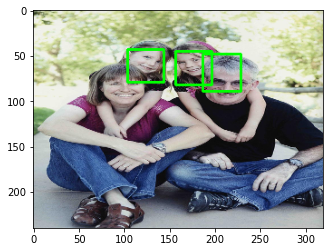

In [59]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))

- cd ~/aiffel/face_detector && python inference.py  checkpoints/  image.jpg 

### 프로젝트 :  dlib 을 이용한 스티커 합성

In [60]:
import dlib

detector_hog = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./aiffel/face_detector/shape_predictor_68_face_landmarks.dat')
img_sticker = cv2.imread('./king.png')

In [61]:
def img2sticker(img_orig, img_sticker, detector_hog, landmark_predictor):
    # preprocess
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_bgr = img_orig.copy()
    
    # detector
    dlib_rects = detector_hog(img_rgb, 0)
    if len(dlib_rects) < 1:
        return img_orig
    
    # landmark
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    
    # head coord
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0] # nose
        y = landmark[30][1] - dlib_rect.width()//2
        w = dlib_rect.width()
        h = dlib_rect.width()
        # break
    
        # sticker
        img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_NEAREST)

        refined_x = x - w // 2
        refined_y = y - h

        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:]
            refined_y = 0

        if refined_x < 0:
            img_sticker = img_sticker[:, -refined_x:]
            refined_x = 0
        elif refined_x + img_sticker.shape[1] >= img_orig.shape[1]:
            img_sticker = img_sticker[:, :-(img_sticker.shape[1]+refined_x-img_orig.shape[1])]


        sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

        img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.7, 0)

    return img_bgr

In [62]:
img_path = os.getenv('HOME')+'/aiffel/face_detector/image.jpg'

img_orig = cv2.imread(img_path)

img_bgr = img2sticker(img_orig, img_sticker, detector_hog, landmark_predictor)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

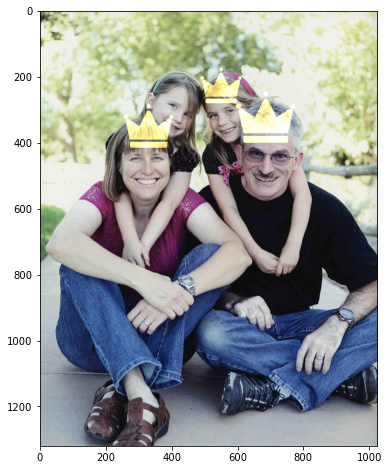

In [63]:
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)

### 정리
- 여러 사진들을 해봤는데 SSD 모델로 검색이 잘 되지않아 dlib을 사용하여 landmark를 검색하였으나 그 마저도 옆얼굴이나 정면임에도 모두를 검출해내지는 못했다.
